In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
import time
from tqdm import tqdm
import json
import scg
import importlib
import lfrog
from contextlib import redirect_stdout
from autorank import autorank, plot_stats
import scikit_posthocs as sp
import io
import warnings
warnings.filterwarnings('ignore')

In [5]:
seed = 40
torch.manual_seed(seed)
np.random.seed(seed)

### Loading and downsampling data

In [28]:
data = pd.read_csv('../data/xor_data.csv')

y = data['y']
X = data.drop(columns='y')

sss = StratifiedShuffleSplit(n_splits=1, train_size=10000, random_state=42)
for train_idx, _ in sss.split(X, y):
    X_s = X.iloc[train_idx]
    y_s = y.iloc[train_idx]

### K-fold setup

In [29]:
def generate_folds(X, y, n_folds = 10):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    folds = []
    splits = kf.split(X, y)
    for train_index, val_index in splits:
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        folds.append({'Xt': X_train, 'Xv': X_val, 'yt': y_train, 'yv': y_val})
    return folds

In [30]:
folds = generate_folds(X_s, y_s, 10)

### Auxiliary functions

In [6]:
def extend_with_last(arr, target_length):
    return arr + [arr[-1]] * (target_length - len(arr)) 

class FeedforwardNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.act = nn.ReLU()  
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

def plot_results(results_in, show=True, title='Loss Curve for Classification Problem', fold_i='', ytop=0.8): 
    plt.plot(results_in['train_losses_by_epochs'], label=f'Train Loss: {fold_i}')
    plt.plot(results_in['val_losses'], label=f'Validation Loss: {fold_i}')
    plt.ylim(0, ytop) 
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    if show == True:
        plt.legend()
        plt.show()

class CustomJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        try:
            return super().default(obj)
        except TypeError:
            pass
        if hasattr(obj, '__dict__'):
            return obj.__dict__
        elif hasattr(obj, '__str__'):
            return str(obj)
        else:
            return f"<non-serializable: {type(obj).__name__}>"

def save_json(data, path, indent=4):
    with open(path, "w") as f:
        json.dump(data, f, indent=indent, cls=CustomJSONEncoder)

def extract_losses_and_accuracy(results):
    out = {}
    for dim_key in list(results.keys()):
        out_folds = {}
        for fold_key in list(results[dim_key].keys()):
            data = results[dim_key][fold_key]
            temp = {}
            temp['train_losses_by_epochs'] = data['train_losses_by_epochs']
            temp['val_losses'] = data['val_losses']
            temp['train_accs'] = data['train_accs']
            temp['val_accs'] = data['val_accs']
            temp['global_duration'] = data['global_duration']
            temp['epoch_durations'] = data['epoch_durations']
            temp['total_epochs'] = data['total_epochs']
            out_folds[fold_key] = temp
        out[dim_key] = out_folds
    return out

def plot_per_dim(dim_results, title="Loss Curve for Classification Problem 1: Hidden dimension = 1"):
    for key in list(dim_results.keys()):
        plot_results(dim_results[key], show=False, fold_i=key, title=title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.3))
    plt.tight_layout()    
    plt.show()

def find_time_to_convergence(results_folded, threshold=0.005, max_time=1e6):
    out = {}
    val_wall = []
    val_epoch = []
    train_wall = []
    train_epoch = []
    for key in list(results_folded.keys()):
        val_wall.append(convergence_time(results_folded[key], threshold=threshold, max_time=max_time, key='val_losses', wall_time=True))
        val_epoch.append(convergence_time(results_folded[key], threshold=threshold, max_time=max_time, key='val_losses', wall_time=False))
        train_wall.append(convergence_time(results_folded[key], threshold=threshold, max_time=max_time, key='train_losses_by_epochs', wall_time=True))
        train_epoch.append(convergence_time(results_folded[key], threshold=threshold, max_time=max_time, key='train_losses_by_epochs', wall_time=False))
    out['val_wall'] = val_wall
    out['val_epoch'] = val_epoch
    out['train_wall'] = train_wall
    out['train_epoch'] = train_epoch
    return out

def convergence_time(result_run, threshold=0.005, max_time=1e6, key='val_losses', wall_time=True):
    list_in = np.array(result_run[key])
    n = len(list_in)
    for i in range(n):
        if all(v < threshold for v in list_in[i:]):
            if wall_time == True:
                out = np.array(result_run['epoch_durations'])
                return float(np.sum(out[:i + 1]))
            else: 
                return float(i + 1)
    return max_time

def estimate_avg_time_to_convergence(results_folded, threshold=0.005, max_time=1e6):
    res = find_time_to_convergence(results_folded, threshold, max_time)
    out = {}

    out['val_wall_avg'] = float(np.mean(res['val_wall']))
    out['val_wall_std'] = float(np.std(res['val_wall']))

    out['val_epoch_avg'] = float(np.mean(res['val_epoch']))
    out['val_epoch_std'] = float(np.std(res['val_epoch']))

    out['train_wall_avg'] = float(np.mean(res['train_wall']))
    out['train_wall_std'] = float(np.std(res['train_wall']))

    out['train_epoch_avg'] = float(np.mean(res['train_epoch']))
    out['train_epoch_std'] = float(np.std(res['train_epoch']))
    return out

def find_best_config(results, test_key='val_wall', threshold=0.05):
    best_key = None
    best_result = np.inf
    for key in list(results.keys()):
        temp = estimate_avg_time_to_convergence(results[key], threshold=threshold)[f"{test_key}_avg"]
        if temp < best_result:
            best_result = temp
            best_key = key
    return {'config': best_key, 'metric': best_result}

def sort_configs(results, test_key='val_wall', threshold=0.05):
    sorted_keys = sorted(
        results.keys(),
        key=lambda k: estimate_avg_time_to_convergence(results[k], threshold=threshold)[f"{test_key}_avg"],
        reverse=False
    )
    return sorted_keys

## SGD

### Model Training function

In [115]:
def train_sgd_model(fold, hidden_dim=2, input_dim = 2, output_dim = 2, batch_size=1, learning_rate = 0.01, max_epochs=10, to_print=True, patience=10): 
    X_val = torch.tensor(fold['Xv'].values, dtype=torch.float32)
    y_val = torch.tensor(fold['yv'].values, dtype=torch.long)
    X_train = torch.tensor(fold['Xt'].values, dtype=torch.float32)
    y_train = torch.tensor(fold['yt'].values, dtype=torch.long)

    train_dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = FeedforwardNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []
    best_val_loss = float('inf')
    epochs_since_improve = 0
    global_start = time.time()
    total_epochs_ran = 0
    for epoch in range(max_epochs):
        local_start = time.time()
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for batch_X, batch_y in loader: 
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        
        avg_train_loss = train_loss / total
        train_acc = correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)              
            val_loss = criterion(val_outputs, y_val).item()  
            _, val_pred = torch.max(val_outputs, 1)
            val_correct = 0
            val_total = y_val.size(0)
            val_correct = (val_pred == y_val).sum().item()
            val_acc = val_correct / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

        if val_loss < best_val_loss - 1e-6:  
            best_val_loss = val_loss
            epochs_since_improve = 0
        else:
            epochs_since_improve += 1

        local_stop = time.time()
        local_duration = local_stop - local_start
        times.append(local_duration)
        total_epochs_ran += 1

        if to_print == True:
            print(f"Epoch {epoch+1}/{max_epochs} | "
                f"Train Loss: {avg_train_loss:.4f} | "
                f"Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f} | "
                f"Val Acc: {val_acc:.4f} | "
                f"Duration: {local_duration:.4f}")
            
        if epochs_since_improve >= patience:
            if to_print == True:
                print(f"Early stopping at epoch {epoch+1}")
            break
            
    global_end = time.time()
    global_duration = global_end - global_start

    results = {
        "model": model,
        "train_losses_by_epochs": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "global_duration": global_duration, 
        "epoch_durations": times,
        "total_epochs": total_epochs_ran
    }
    return results

### Evals of dimension and learning rate

Epoch 1/10 | Train Loss: 0.3084 | Train Acc: 0.8880 | Val Loss: 0.0452 | Val Acc: 0.9980 | Duration: 5.0871
Epoch 2/10 | Train Loss: 0.0252 | Train Acc: 0.9998 | Val Loss: 0.0167 | Val Acc: 0.9980 | Duration: 5.0000
Epoch 3/10 | Train Loss: 0.0123 | Train Acc: 0.9999 | Val Loss: 0.0110 | Val Acc: 0.9980 | Duration: 4.6375
Epoch 4/10 | Train Loss: 0.0084 | Train Acc: 0.9999 | Val Loss: 0.0090 | Val Acc: 0.9980 | Duration: 4.8647
Epoch 5/10 | Train Loss: 0.0065 | Train Acc: 0.9999 | Val Loss: 0.0070 | Val Acc: 0.9980 | Duration: 5.0915
Epoch 6/10 | Train Loss: 0.0053 | Train Acc: 0.9999 | Val Loss: 0.0068 | Val Acc: 0.9980 | Duration: 4.6938
Epoch 7/10 | Train Loss: 0.0045 | Train Acc: 0.9998 | Val Loss: 0.0058 | Val Acc: 0.9980 | Duration: 4.6384
Epoch 8/10 | Train Loss: 0.0040 | Train Acc: 0.9999 | Val Loss: 0.0050 | Val Acc: 0.9980 | Duration: 4.6205
Epoch 9/10 | Train Loss: 0.0035 | Train Acc: 0.9999 | Val Loss: 0.0047 | Val Acc: 0.9980 | Duration: 5.7992
Epoch 10/10 | Train Loss: 0.

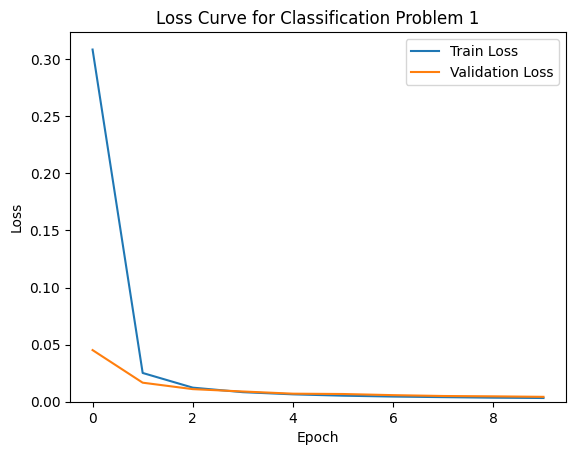

In [114]:
res = train_sgd_model(folds[0], hidden_dim=2, max_epochs=10)
plot_results(res)

In [117]:
def find_optimal_hidden_layers(folds, dim_list = [1, 2, 3], max_epochs=20, learning_rate=0.01):
    results = {}
    for n in dim_list:
        results_per_size = {}
        for i in tqdm(range(len(folds))):
            results_per_size[f'fold_{i}'] = train_sgd_model(folds[i], hidden_dim=n, max_epochs=max_epochs, learning_rate=learning_rate, to_print=False)
        results[f'dim_{n}'] = results_per_size
    return results 

In [142]:
dim_results_45 = find_optimal_hidden_layers(folds, dim_list=[4, 5])
save_json(extract_losses_and_accuracy(dim_results_45), '../results/classification_1/hidden_dim_test_45.json')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [15:49<00:00, 94.94s/it]


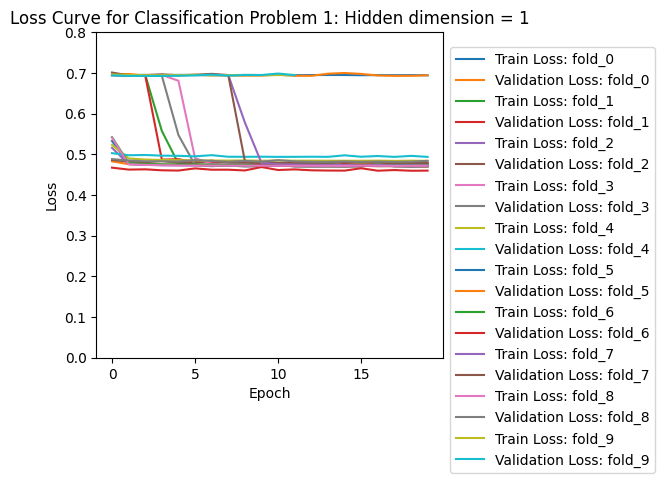

In [139]:
plot_per_dim(dim_results['dim_1'], title="Loss Curve for Classification Problem 1: Hidden dimension = 1")

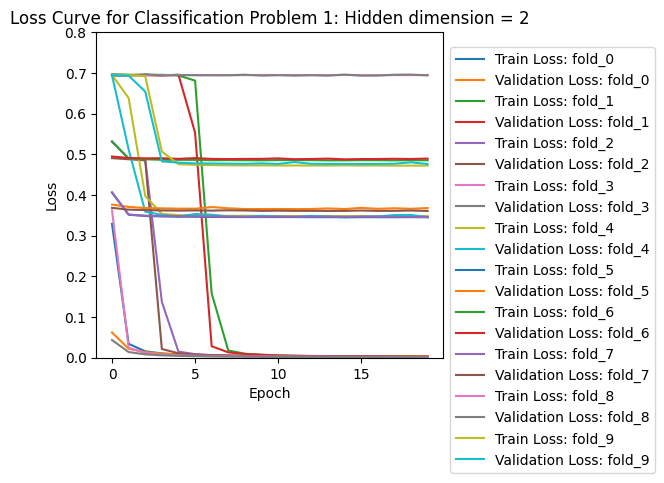

In [148]:
plot_per_dim(dim_results['dim_2'], title="Loss Curve for Classification Problem 1: Hidden dimension = 2")

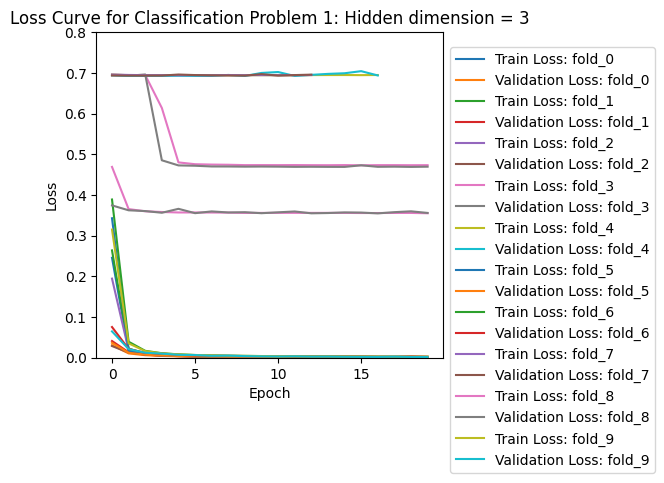

In [147]:
plot_per_dim(dim_results['dim_3'], title="Loss Curve for Classification Problem 1: Hidden dimension = 3")

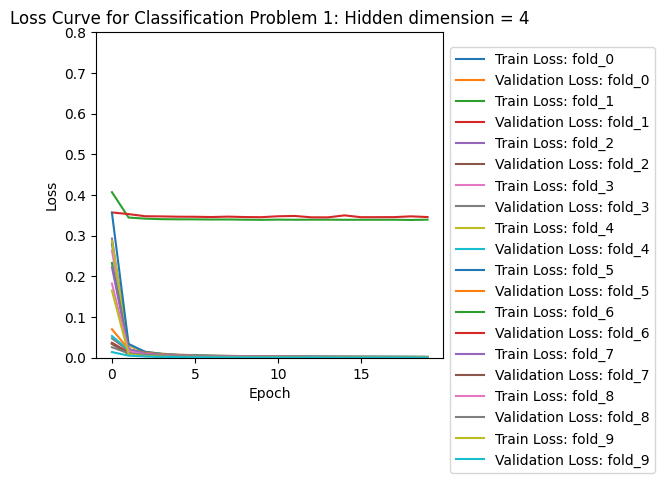

In [146]:
plot_per_dim(dim_results_45['dim_4'], title="Loss Curve for Classification Problem 1: Hidden dimension = 4")

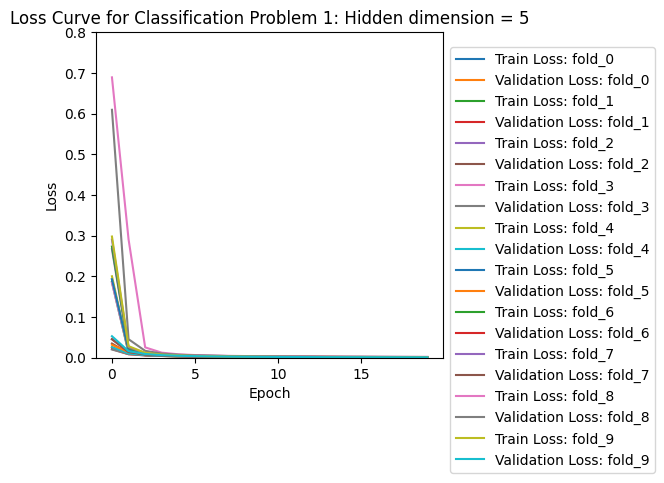

In [145]:
plot_per_dim(dim_results_45['dim_5'], title="Loss Curve for Classification Problem 1: Hidden dimension = 5")

In [179]:
def find_optimal_learning_rate(folds, lr_list = [1, 2, 3], max_epochs=20):
    results = {}
    for l in lr_list:
        results_per_size = {}
        for i in tqdm(range(len(folds))):
            results_per_size[f'fold_{i}'] = train_sgd_model(folds[i], hidden_dim=5, max_epochs=max_epochs, learning_rate=l, to_print=False, patience=10)
        results[f'lr_{l}'] = results_per_size
    return results 

In [180]:
lr_candidates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]

dim_results_lr = find_optimal_learning_rate(folds, lr_list=lr_candidates)
save_json(extract_losses_and_accuracy(dim_results_lr), '../results/classification_1/lr_test.json')

100%|██████████| 10/10 [16:38<00:00, 99.85s/it] 


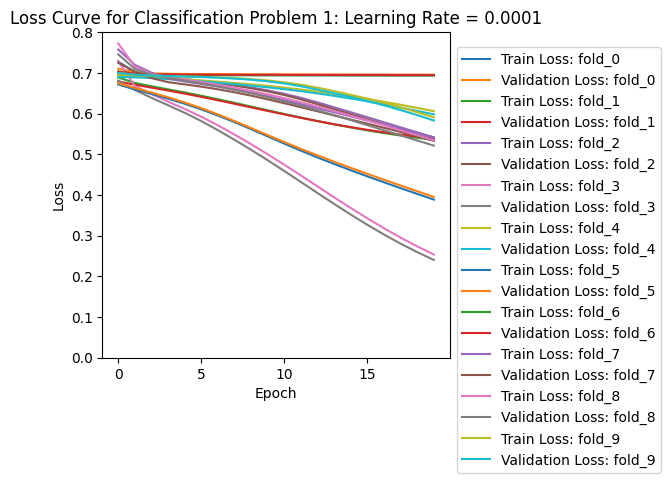

In [181]:
plot_per_dim(dim_results_lr['lr_0.0001'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.0001")

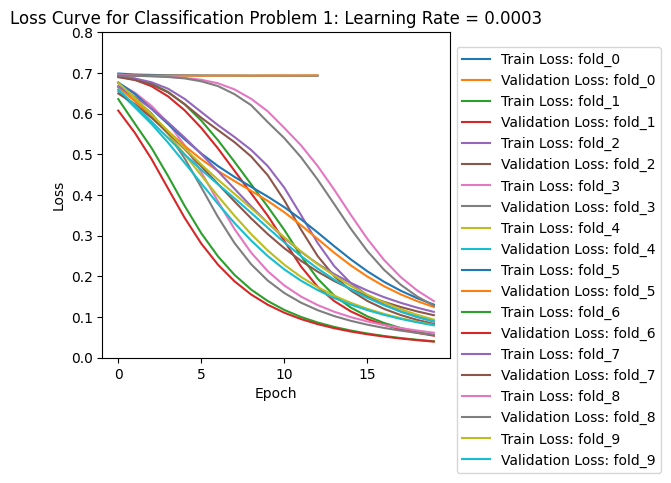

In [182]:
plot_per_dim(dim_results_lr['lr_0.0003'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.0003")

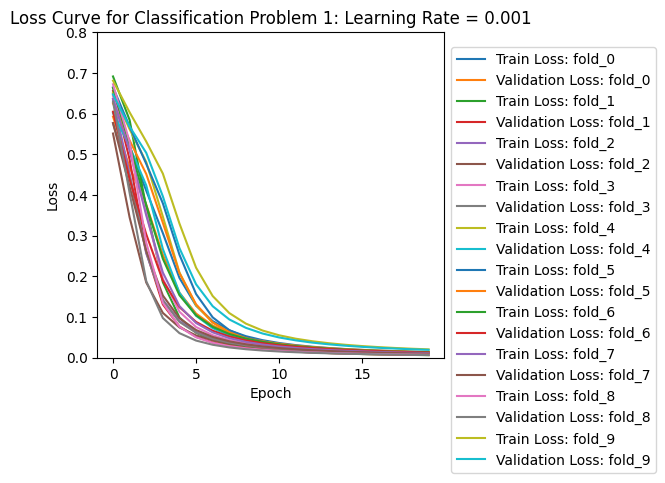

In [183]:
plot_per_dim(dim_results_lr['lr_0.001'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.001")

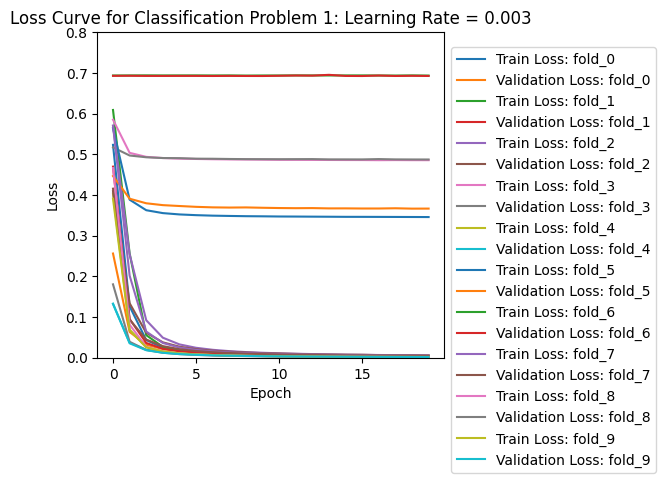

In [184]:
plot_per_dim(dim_results_lr['lr_0.003'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.003")

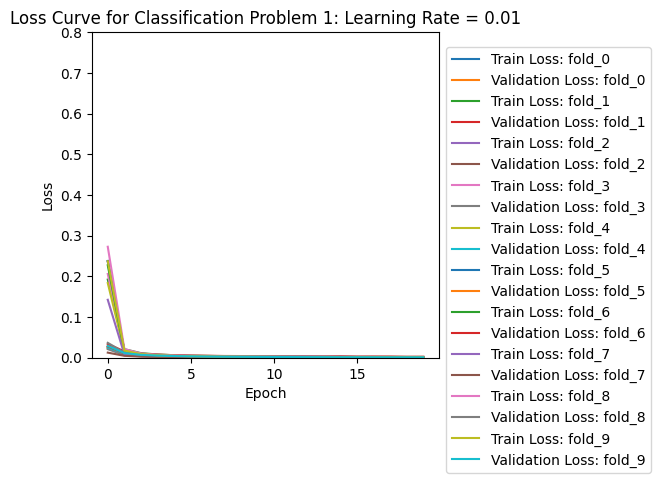

In [186]:
plot_per_dim(dim_results_lr['lr_0.01'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.01")

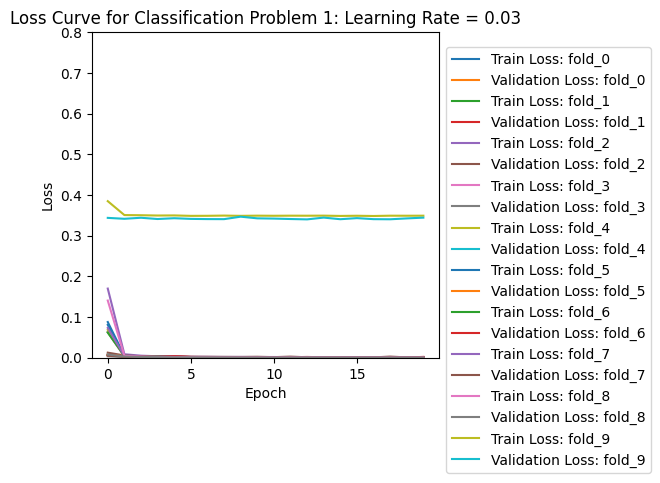

In [187]:
plot_per_dim(dim_results_lr['lr_0.03'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.03")

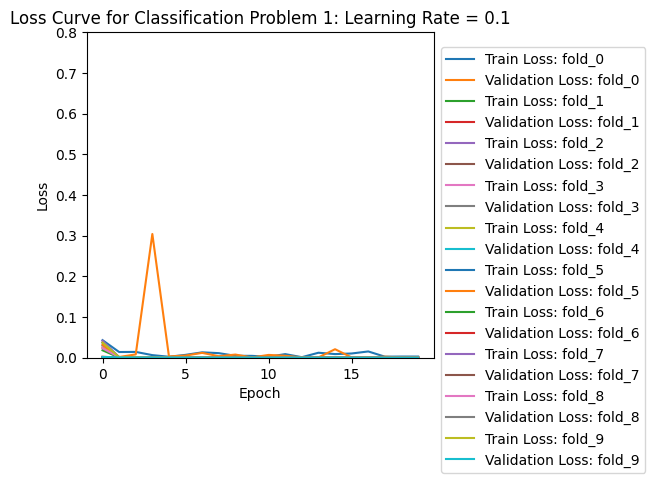

In [188]:
plot_per_dim(dim_results_lr['lr_0.1'], title="Loss Curve for Classification Problem 1: Learning Rate = 0.1")

## SCG

In [166]:
importlib.reload(scg)
from scg import SCG

def train_scg_model(
    fold,
    hidden_dim=5,
    input_dim=2,
    output_dim=2,
    max_epochs=10,
    sigma=1e-4,
    lambd=1e-6,
    to_print=True,
    patience=10
):
    X_val = torch.tensor(fold['Xv'].values, dtype=torch.float32)
    y_val = torch.tensor(fold['yv'].values, dtype=torch.long)
    X_train = torch.tensor(fold['Xt'].values, dtype=torch.float32)
    y_train = torch.tensor(fold['yt'].values, dtype=torch.long)

    model = FeedforwardNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = SCG(model.parameters(), sigma=sigma, lambd=lambd)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []
    best_val_loss = float('inf')
    epochs_since_improve = 0
    global_start = time.time()
    total_epochs_ran = 0

    for epoch in range(max_epochs):
        local_start = time.time()
        model.train()

        def closure():
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            return loss

        loss = optimizer.step(closure)
        train_loss = loss.item()

        with torch.no_grad():
            outputs = model(X_train)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == y_train).sum().item()
            total = y_train.size(0)
            train_acc = correct / total

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            _, val_pred = torch.max(val_outputs, 1)
            val_correct = (val_pred == y_val).sum().item()
            val_total = y_val.size(0)
            val_acc = val_correct / val_total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            epochs_since_improve = 0
        else:
            epochs_since_improve += 1

        local_stop = time.time()
        local_duration = local_stop - local_start
        times.append(local_duration)
        total_epochs_ran += 1

        if to_print:
            print(f"Epoch {epoch+1}/{max_epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val Acc: {val_acc:.4f} | "
                  f"Duration: {local_duration:.4f}")

        if epochs_since_improve >= patience:
            if to_print:
                print(f"Early stopping at epoch {epoch+1}")
            break

    global_end = time.time()
    global_duration = global_end - global_start

    results = {
        "model": model,
        "train_losses_by_epochs": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "global_duration": global_duration,
        "epoch_durations": times,
        "total_epochs": total_epochs_ran
    }
    return results


In [267]:
def optimize_hyper_params_scg(folds, sig_list, lam_list, max_epochs=1000):
    results = {}
    for s in sig_list:
        for l in lam_list:
            results_per_config = {}
            for i in tqdm(range(len(folds))):
                results_per_config[f'fold_{i}'] = train_scg_model(folds[i], max_epochs=max_epochs, sigma=s, lambd=l, to_print=False, patience=1000)
            results[f'sigma_{s}_lambda_{l}'] = results_per_config
    return results 

In [268]:
sigmas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
lambdas = [1e-6, 1e-5, 1e-4]

scg_param_results = optimize_hyper_params_scg(folds, sigmas, lambdas)
save_json(extract_losses_and_accuracy(scg_param_results), '../results/classification_1/scg_hyperparam_test.json')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


In [270]:
sort_configs(scg_param_results, threshold=0.05)

['sigma_0.0001_lambda_0.0001',
 'sigma_1e-05_lambda_1e-05',
 'sigma_0.0003_lambda_0.0001',
 'sigma_0.0001_lambda_1e-06',
 'sigma_1e-06_lambda_1e-06',
 'sigma_3e-06_lambda_1e-06',
 'sigma_3e-05_lambda_1e-05',
 'sigma_0.0003_lambda_1e-05',
 'sigma_3e-06_lambda_1e-05',
 'sigma_0.0003_lambda_1e-06',
 'sigma_3e-06_lambda_0.0001',
 'sigma_1e-05_lambda_0.0001',
 'sigma_1e-05_lambda_1e-06',
 'sigma_1e-06_lambda_1e-05',
 'sigma_3e-05_lambda_0.0001',
 'sigma_1e-06_lambda_0.0001',
 'sigma_3e-05_lambda_1e-06',
 'sigma_0.0001_lambda_1e-05']

In [271]:
estimate_avg_time_to_convergence(scg_param_results['sigma_0.0001_lambda_0.0001'], threshold=0.1)

{'val_wall_avg': 0.35477285385131835,
 'val_wall_std': 0.1454466158440327,
 'val_epoch_avg': 53.2,
 'val_epoch_std': 22.457960726655482,
 'train_wall_avg': 0.35270659923553466,
 'train_wall_std': 0.14236678233829914,
 'train_epoch_avg': 52.9,
 'train_epoch_std': 21.920082116634507}

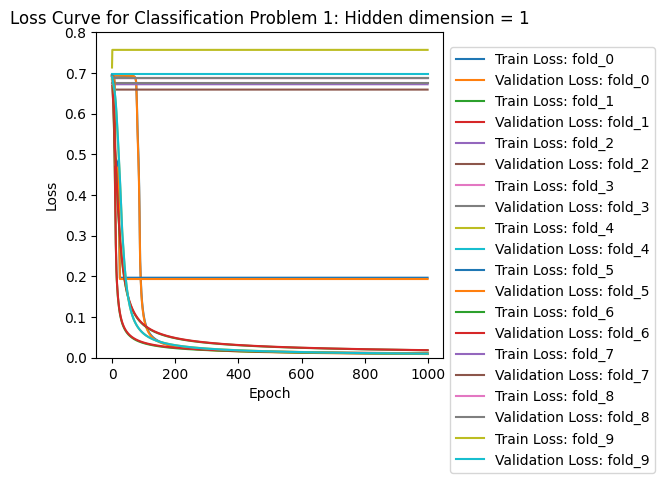

In [273]:
plot_per_dim(scg_param_results['sigma_0.0001_lambda_1e-05'])

## LFrog

In [195]:
importlib.reload(lfrog)
from lfrog import LeapfrogOptimizer

def train_leapfrog_model(
    fold,
    hidden_dim=5,
    input_dim=2,
    output_dim=2,
    max_epochs=10,
    time_step=0.5,
    delta_max=1.0,
    tol_grad=1e-5,
    j_threshold=2,
    to_print=True,
    patience=10
):
    # Prepare data
    X_val = torch.tensor(fold['Xv'].values, dtype=torch.float32)
    y_val = torch.tensor(fold['yv'].values, dtype=torch.long)
    X_train = torch.tensor(fold['Xt'].values, dtype=torch.float32)
    y_train = torch.tensor(fold['yt'].values, dtype=torch.long)

    model = FeedforwardNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    criterion = nn.CrossEntropyLoss()

    optimizer = LeapfrogOptimizer(
        model.parameters(),
        time_step=time_step,
        delta_max=delta_max,
        tol_grad=tol_grad,
        j_threshold=j_threshold
    )

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []
    best_val_loss = float('inf')
    epochs_since_improve = 0
    global_start = time.time()
    total_epochs_ran = 0

    for epoch in range(max_epochs):
        local_start = time.time()
        model.train()

        # Closure for Leapfrog: must compute full-batch loss + backward
        def closure():
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            return loss

        # Step the optimizer (standard PyTorch style)
        loss = optimizer.step(closure)
        train_loss = loss.item()

        with torch.no_grad():
            outputs = model(X_train)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == y_train).sum().item()
            total = y_train.size(0)
            train_acc = correct / total

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            _, val_pred = torch.max(val_outputs, 1)
            val_correct = (val_pred == y_val).sum().item()
            val_total = y_val.size(0)
            val_acc = val_correct / val_total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            epochs_since_improve = 0
        else:
            epochs_since_improve += 1

        local_stop = time.time()
        local_duration = local_stop - local_start
        times.append(local_duration)
        total_epochs_ran += 1

        if to_print:
            grad_norm = optimizer.grad_norm()
            print(f"Epoch {epoch+1}/{max_epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val Acc: {val_acc:.4f} | "
                  f"Grad Norm: {grad_norm:.4e} | "
                  f"Duration: {local_duration:.4f}")

        if epochs_since_improve >= patience:
            if to_print:
                print(f"Early stopping at epoch {epoch+1}")
            break

        # optional: stop early if gradient norm below tolerance
        if optimizer.grad_norm() <= tol_grad:
            if to_print:
                print(f"Converged at epoch {epoch+1}")
            break

    global_end = time.time()
    global_duration = global_end - global_start

    results = {
        "model": model,
        "train_losses_by_epochs": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "global_duration": global_duration,
        "epoch_durations": times,
        "total_epochs": total_epochs_ran
    }
    return results

In [261]:
def optimize_hyper_params_lfrog(folds, time_list, delta_list, j_list, max_epochs=1000):
    results = {}
    for t in time_list:
        for d in delta_list:
            for j in j_list:
                results_per_config = {}
                for i in tqdm(range(len(folds))):
                    results_per_config[f'fold_{i}'] = train_leapfrog_model(folds[i], max_epochs=max_epochs, time_step=t, delta_max=d, j_threshold=j, to_print=False, patience=1000)
                results[f'timestep_{t}_delta_{d}_J_{j}'] = results_per_config
    return results 

In [262]:
time_list = [0.1, 0.25, 0.5, 0.75, 1.0]
delta_list = [0.5, 1.0, 1.5, 2.0]
j_list = [1, 2, 3, 4]

lfrog_param_results = optimize_hyper_params_lfrog(folds, time_list, delta_list, j_list)
save_json(extract_losses_and_accuracy(lfrog_param_results), '../results/classification_1/lfrog_hyperparam_test.json')

100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


In [263]:
sort_configs(lfrog_param_results)

['timestep_1.0_delta_2.0_J_2',
 'timestep_0.75_delta_1.0_J_1',
 'timestep_1.0_delta_1.5_J_3',
 'timestep_1.0_delta_2.0_J_4',
 'timestep_1.0_delta_2.0_J_1',
 'timestep_0.5_delta_2.0_J_3',
 'timestep_0.5_delta_1.0_J_1',
 'timestep_0.5_delta_0.5_J_2',
 'timestep_0.5_delta_2.0_J_1',
 'timestep_0.25_delta_1.5_J_3',
 'timestep_0.25_delta_1.0_J_2',
 'timestep_0.25_delta_1.5_J_2',
 'timestep_0.25_delta_2.0_J_4',
 'timestep_0.25_delta_1.5_J_1',
 'timestep_0.75_delta_0.5_J_1',
 'timestep_0.5_delta_0.5_J_1',
 'timestep_0.1_delta_0.5_J_4',
 'timestep_0.1_delta_2.0_J_4',
 'timestep_0.75_delta_2.0_J_1',
 'timestep_0.75_delta_1.0_J_4',
 'timestep_0.75_delta_0.5_J_4',
 'timestep_1.0_delta_1.0_J_2',
 'timestep_0.75_delta_1.5_J_1',
 'timestep_0.75_delta_1.0_J_3',
 'timestep_1.0_delta_0.5_J_1',
 'timestep_1.0_delta_0.5_J_2',
 'timestep_0.5_delta_1.5_J_3',
 'timestep_1.0_delta_2.0_J_3',
 'timestep_0.5_delta_0.5_J_3',
 'timestep_0.75_delta_2.0_J_2',
 'timestep_1.0_delta_1.0_J_1',
 'timestep_0.5_delta_1.5_J

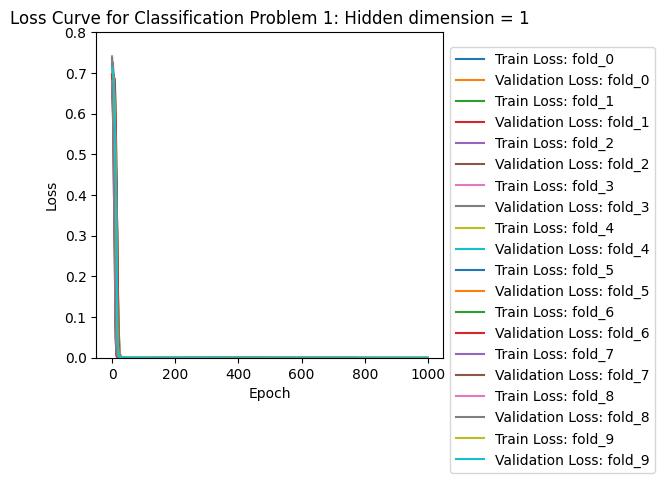

In [266]:
plot_per_dim(lfrog_param_results['timestep_1.0_delta_2.0_J_2'])

In [265]:
estimate_avg_time_to_convergence(lfrog_param_results['timestep_1.0_delta_2.0_J_2'])

{'val_wall_avg': 0.10776848793029785,
 'val_wall_std': 0.020444467076148484,
 'val_epoch_avg': 22.1,
 'val_epoch_std': 4.109744517606903,
 'train_wall_avg': 0.1035015344619751,
 'train_wall_std': 0.016644018701974395,
 'train_epoch_avg': 21.2,
 'train_epoch_std': 3.867815921162743}

## Evals

### Val wall time

In [10]:
def stat_tests(sgd, scg, lfrog, metric, signifigance_level = 0.05, conv_threshold = 0.05):

    best_sgd_key = sort_configs(sgd, threshold=conv_threshold, test_key=metric)[0]
    best_scg_key = sort_configs(scg, threshold=conv_threshold, test_key=metric)[0]
    best_lfrog_key = sort_configs(lfrog, threshold=conv_threshold, test_key=metric)[0]

    sgd_data = find_time_to_convergence(dim_results_lr[best_sgd_key], threshold=conv_threshold)[metric]
    scg_data = find_time_to_convergence(scg_param_results[best_scg_key], threshold=conv_threshold)[metric]
    lfrog_data = find_time_to_convergence(lfrog_param_results[best_lfrog_key], threshold=conv_threshold)[metric]

    column_names = [f'fold {i}' for i in range(10)]
    df = pd.DataFrame([sgd_data, scg_data, lfrog_data], columns=column_names) 
    df = df.T
    df.columns = ['SGD', 'SCG', 'LFROG']

    map = {
        'val_wall': 'Validation Wall Time (Time to Convergence)',
        'val_epoch': 'Validation Epochs (Epochs to Convergence)', 
        'train_wall': 'Training Wall Time (Time to Convergence)',
        'train_epoch': 'Training Epochs (Epochs to Convergence)'
        }

    posthoc_results = sp.posthoc_nemenyi_friedman(df)
    plt.title(f'Signifigance Plot between best KNN and DT models based on {map[metric]}')
    sp.sign_plot(posthoc_results)
    plt.title('p-value')
    plt.show

    f = io.StringIO()
    with redirect_stdout(f):
        results = autorank(df, alpha=signifigance_level, verbose=False, force_mode='nonparametric', order='ascending')
    plot_stats(results)
    plt.title(f'Critical Distance plot based on {map[metric]}')
    plt.show()

    ranking_order = results.rankdf.index.tolist()
    for k in ranking_order:
        if k == 'SGD':
            out = estimate_avg_time_to_convergence(sgd[best_sgd_key], threshold=conv_threshold)
            key_out = best_sgd_key
        if k == 'SCG':
            out = estimate_avg_time_to_convergence(scg[best_scg_key], threshold=conv_threshold)
            key_out = best_scg_key

        if k == 'LFROG':
            out = estimate_avg_time_to_convergence(lfrog[best_lfrog_key], threshold=conv_threshold)
            key_out = best_lfrog_key
        print(f"{k}: {out[metric+'_avg']} ± {out[metric+'_std']} \t\t params: {key_out}")

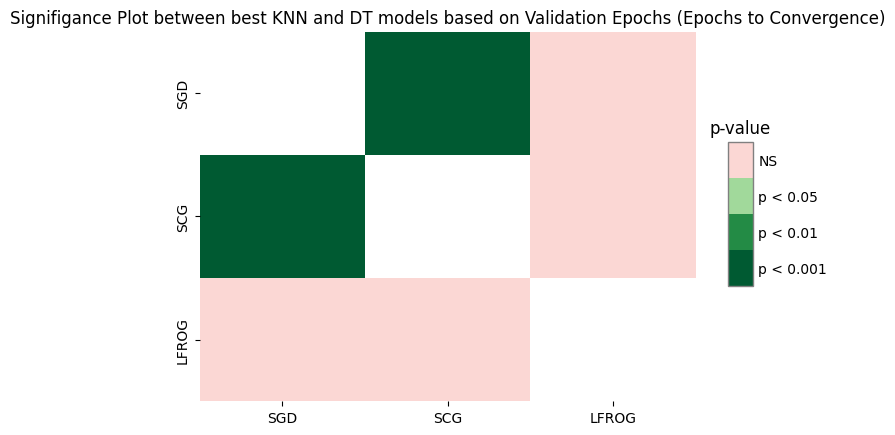

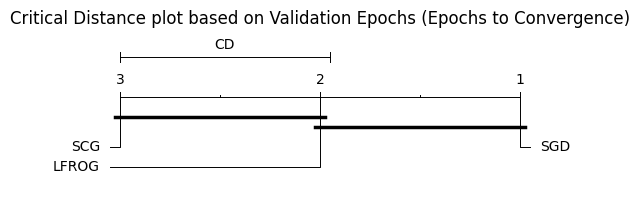

SGD: 1.9 ± 0.3 		 params: lr_0.01
LFROG: 18.5 ± 3.4132096331752027 		 params: timestep_1.0_delta_2.0_J_2
SCG: 513.4 ± 203.29545002286696 		 params: sigma_0.0001_lambda_0.0001


In [13]:
stat_tests(dim_results_lr, scg_param_results, lfrog_param_results, metric='val_epoch', signifigance_level=0.05, conv_threshold = 0.02)

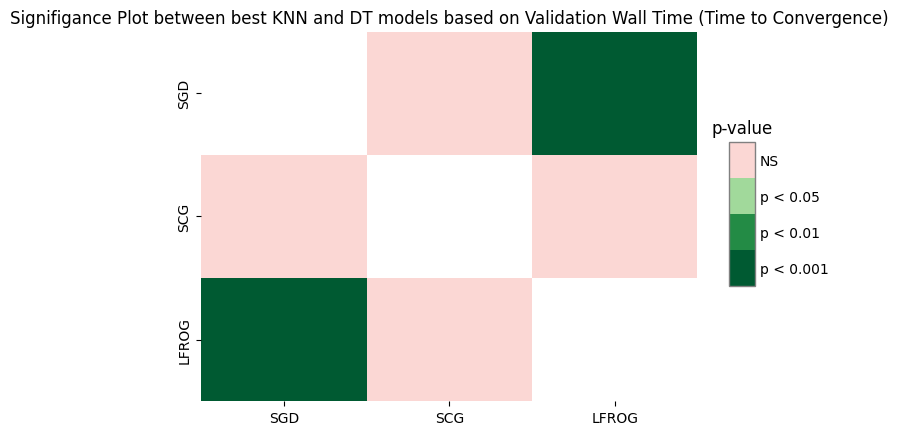

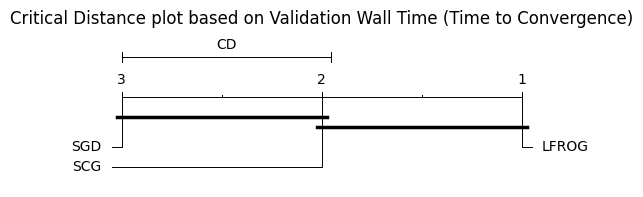

LFROG: 0.09091975688934326 ± 0.014739841750902287 		 params: timestep_1.0_delta_2.0_J_2
SCG: 3.582702898979187 ± 1.3598587313899375 		 params: sigma_0.0001_lambda_0.0001
SGD: 11.613003969192505 ± 1.876957301646864 		 params: lr_0.01


In [14]:
stat_tests(dim_results_lr, scg_param_results, lfrog_param_results, metric='val_wall', signifigance_level=0.05, conv_threshold = 0.02)

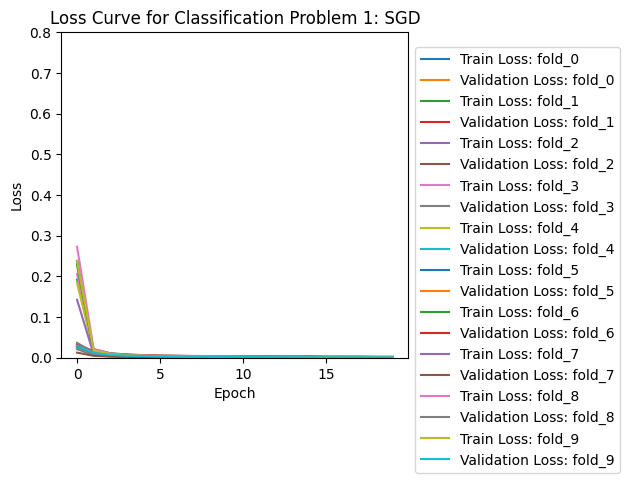

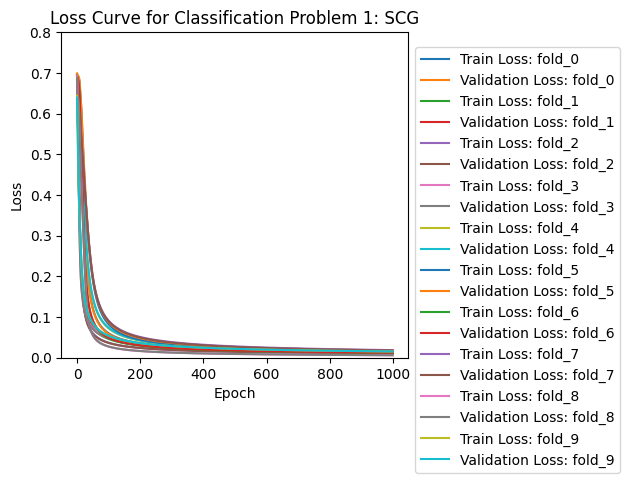

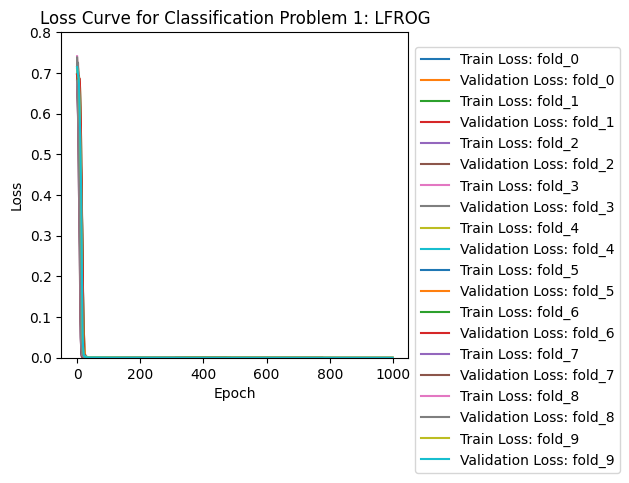

In [15]:
plot_per_dim(dim_results_lr['lr_0.01'], title="Loss Curve for Classification Problem 1: SGD")
plot_per_dim(scg_param_results['sigma_0.0001_lambda_0.0001'], title="Loss Curve for Classification Problem 1: SCG")
plot_per_dim(lfrog_param_results['timestep_1.0_delta_2.0_J_2'], title="Loss Curve for Classification Problem 1: LFROG")

In [9]:
def load_json_file(filename):
    with open(filename, 'r') as file:
        return json.load(file)

dim_results_lr = load_json_file('../results/classification_1/lr_test.json')
scg_param_results = load_json_file('../results/classification_1/scg_hyperparam_test.json')
lfrog_param_results = load_json_file('../results/classification_1/lfrog_hyperparam_test.json')

In [17]:
def hidden_dim_table_sgd(data, conv_threshold=0.05, top=5):
    top_n = sort_configs(data, threshold=conv_threshold, test_key='val_wall')[0:5]
    out = {}
    for x in top_n:
        out[x] = estimate_avg_time_to_convergence(data[x], threshold=conv_threshold)
        evals = []
        for i in range(10):
            evals.append(data[x][f'fold_{i}']['val_accs'][-1])
        out[x]['eval_avg'] = np.mean(evals)
        out[x]['eval_std'] = np.std(evals)
    return pd.DataFrame(out).T

def df_to_latex_table(
    df: pd.DataFrame,
    caption: str = "Validation performance across different hyperparameters.",
    label: str = "tab:val_results",
    hyperparam_col_width: str = "4cm"  # adjust width as needed
) -> str:
    """
    Convert a DataFrame with arbitrary hyperparameter strings into a LaTeX table.
    - Combines mean ± std for validation wall time, epochs, and eval (R² value)
    - Formats hyperparameters into math mode key=value
    - Keeps hyperparameter column fixed width
    """
    import re

    # Combine mean ± std columns
    val_wall_fmt = df[['val_wall_avg', 'val_wall_std']].round(4).apply(
        lambda row: f"{row['val_wall_avg']} $\\pm$ {row['val_wall_std']}", axis=1
    )
    val_epoch_fmt = df[['val_epoch_avg', 'val_epoch_std']].round(4).apply(
        lambda row: f"{row['val_epoch_avg']} $\\pm$ {row['val_epoch_std']}", axis=1
    )
    evals_fmt = df[['eval_avg', 'eval_std']].round(4).apply(
        lambda row: f"{row['eval_avg']} $\\pm$ {row['eval_std']}", axis=1
    )

    # General hyperparameter formatting: convert key_value to key=value in math mode
    def format_hyperparams(hp_str):
        # Replace underscores with =, keep multiple key_value pairs
        # Example: sigma_0.0001_lambda_0.0001 -> sigma=0.0001, lambda=0.0001
        parts = re.split(r'[_]', hp_str)
        formatted_parts = []
        i = 0
        while i < len(parts):
            if i + 1 < len(parts):
                formatted_parts.append(f"{parts[i]}={parts[i+1]}")
            i += 2
        return "$" + ", ".join(formatted_parts) + "$"

    hyperparams = df.index.to_series().apply(format_hyperparams)

    # Build new DataFrame
    new_df = pd.DataFrame({
        "Hyperparameters": hyperparams,
        "Validation Wall Time": val_wall_fmt,
        "Validation Epochs": val_epoch_fmt,
        "Accuracy Value": evals_fmt
    })

    # Convert to LaTeX tabular with fixed width for hyperparam column
    col_format = f"p{{{hyperparam_col_width}}}ccc"

    tabular = new_df.to_latex(
        index=False,
        escape=False,
        column_format=col_format
    )

    # Wrap into table environment
    latex = (
        "\\begin{table}[H]\n"
        "\\centering\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        f"{tabular}"
        "\\end{table}"
    )

    return latex

prob='c1'

print(df_to_latex_table(hidden_dim_table_sgd(dim_results_lr, conv_threshold=0.02), caption="Top performing SGD hyperparameters", label=f"tab:{prob}_sgd"))
print(df_to_latex_table(hidden_dim_table_sgd(scg_param_results, conv_threshold=0.02), caption="Top performing SCG hyperparameters", label=f"tab:{prob}_scg"))
print(df_to_latex_table(hidden_dim_table_sgd(lfrog_param_results, conv_threshold=0.02), caption="Top performing LFROG hyperparameters", label=f"tab:{prob}_lfrog"))


\begin{table}[H]
\centering
\caption{Top performing SGD hyperparameters}
\label{tab:c1_sgd}
\begin{tabular}{p{4cm}ccc}
\toprule
Hyperparameters & Validation Wall Time & Validation Epochs & R$^2$ Value \\
\midrule
$lr=0.01$ & 11.613 $\pm$ 1.877 & 1.9 $\pm$ 0.3 & 1.0 $\pm$ 0.0 \\
$lr=0.1$ & 12.4682 $\pm$ 22.5163 & 2.5 $\pm$ 4.5 & 1.0 $\pm$ 0.0 \\
$lr=0.001$ & 76.7186 $\pm$ 18.6049 & 13.9 $\pm$ 2.7 & 1.0 $\pm$ 0.0 \\
$lr=0.03$ & 100099.5871 $\pm$ 299966.9359 & 100000.9 $\pm$ 299999.7 & 0.9735 $\pm$ 0.0792 \\
$lr=0.003$ & 300018.2747 $\pm$ 458245.606 & 300003.2 $\pm$ 458255.4746 & 0.9004 $\pm$ 0.1635 \\
\bottomrule
\end{tabular}
\end{table}
\begin{table}[H]
\centering
\caption{Top performing SCG hyperparameters}
\label{tab:c1_scg}
\begin{tabular}{p{4cm}ccc}
\toprule
Hyperparameters & Validation Wall Time & Validation Epochs & R$^2$ Value \\
\midrule
$sigma=0.0001, lambda=0.0001$ & 3.5827 $\pm$ 1.3599 & 513.4 $\pm$ 203.2955 & 1.0 $\pm$ 0.0 \\
$sigma=0.0003, lambda=0.0001$ & 100002.5039 $\pm